# Aim of the Project

The aim of this project is to automatically convert handwritten text into machine encoded text.

# Problem Statement

A medical company needs to take handwritten prescription and retrieve the text from it. To do this manually, it will require a lot of time and lots of cost to the company. So, the company wants to automate this task. You need to create a neural network model that will take images as input, read the text images, and convert it into digital text.

# Dataset Description

**IAM Dataset**

We will be using the IAM dataset for training and testing our model. 

We will use the words subset of the dataset, in which each image contains a word. The dataset contains over 8000 images and their digital text.

# Strategy

The project has 4 major components:
1. Preprocess image and text data
2. Implementation of CNN layers to extract features
3. Implementation of RNN (Bi-LSTM) layers to the sequence model
4. CTC_loss and CTC_decode

# Importing the Primary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow
import keras
from sklearn.model_selection import train_test_split

# Download and Preprocess the Data

In [ ]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading the file and displaying the first 5 lines in parser.txt file
file_path = ('/content/drive/MyDrive/Colab Notebooks/Handwritten Character Recognition/data/parser.txt')
parser_file = open(file_path, 'r')
for i in range(0,5):
  line = parser_file.readline()
  print(line)

a01-000u-00-00 ok 154 408 768 27 51 AT A

a01-000u-00-01 ok 154 507 766 213 48 NN MOVE

a01-000u-00-02 ok 154 796 764 70 50 TO to

a01-000u-00-03 ok 154 919 757 166 78 VB stop

a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.



In [ ]:
#unzip the image data
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Handwritten Character Recognition/data/words.zip"

In [ ]:
#we will take the first 10000 instances from parser file, append the values to a dataframe
target_labels = []
image_paths = []
parser_file.seek(0)
for i in range(0, 10000):
  line = parser_file.readline()
  line_split = line.split()
  folder_split = line_split[0].split('-')
  image_path = ('/content/words/{}/{}-{}/{}.png'.format(folder_split[0], folder_split[0], folder_split[1], line_split[0]))
  #we have err images in the database, therefore, will consider only valid images in first 10K instances.
  if line_split[1] == 'ok':
    image = cv2.imread(image_path)
    try:
      image.shape
      target_labels.append(line_split[-1])
      image_paths.append(image_path)
    except AttributeError:
      print('Error image -- {} -- with incorrect OK validation removed'.format(image_path))

Error image -- /content/words/a01/a01-117/a01-117-05-02.png -- with incorrect OK validation removed


In [ ]:
print('No of Labels:', len(target_labels), '--- Sample label:', target_labels[1])
print('No of Images:', len(image_paths), '--- Sample Image Path:', image_paths[1])

No of Labels: 8725 --- Sample label: MOVE
No of Images: 8725 --- Sample Image Path: /content/words/a01/a01-000u/a01-000u-00-01.png


In [ ]:
y = np.array(target_labels)
y.shape

(8725,)

# Preprocess the Images

Label: MOVE


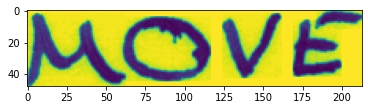

In [ ]:
#visualizing a image
import matplotlib.image as mpimg

img = mpimg.imread(image_paths[1])
plt.imshow(img)
print('Label:', target_labels[1])

Functions for Image preprocessing

In [ ]:
#add padding to the image to avoid distortion while resizing
def add_padding(img, old_w, old_h, new_w, new_h):
  h1, h2 = int((new_h-old_h)/2), int((new_h-old_h)/2)+old_h
  w1, w2 = int((new_w-old_w)/2), int((new_w-old_w)/2)+old_w
  img_pad = np.ones([new_h, new_w, 3]) * 255
  img_pad[h1:h2, w1:w2, :] = img
  return img_pad

In [ ]:
#func to convert all images to a consistent shape
def fix_size(img, target_w, target_h):
  h, w = img.shape[:2]
  if w<target_w and h<target_h:
    img = add_padding(img, w, h, target_w, target_h)
  elif w>=target_w and h<target_h:
    new_w = target_w
    new_h = int(h*new_w/w)
    new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
    img = add_padding(new_img, new_w, new_h, target_w, target_h)
  elif w<target_w and h>=target_h:
    new_h = target_h
    new_w = int(w*new_h/h)
    new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
    img = add_padding(new_img, new_w, new_h, target_w, target_h)
  else:
    '''w>=target_w and h>=target_h '''
    ratio = max(w/target_w, h/target_h)
    new_w = max(min(target_w, int(w / ratio)), 1)
    new_h = max(min(target_h, int(h / ratio)), 1)
    new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
    img = add_padding(new_img, new_w, new_h, target_w, target_h)
  return img

In [ ]:
#function to process the images and normalize
def preprocess(path, img_w, img_h):
  """ Pre-processing image for predicting """
  img = cv2.imread(path)
  img = fix_size(img, img_w, img_h)

  img = np.clip(img, 0, 255)
  img = np.uint8(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  img = img.astype(np.float32)
  img /= 255
  return img

In [ ]:
#process the images and append to a list
X = []

for path in image_paths:
  X.append(preprocess(path, 256, 64))

In [ ]:
X = np.array(X).reshape(-1, 256, 64, 1)
X.shape

(8725, 256, 64, 1)

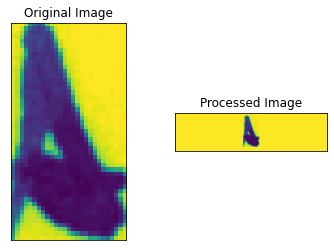

In [201]:
#visualize an image before and after preprocessing
img = mpimg.imread(image_paths[0])
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.title('Processed Image')
plt.imshow(X[0].reshape(64, 256))

# Text Processing

We need to convert the labels to numbers which represent each character in the dataset. The labels are a combination of capitals and small letters in our dataset including digits and special characters.

In [162]:
characters = u"""ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~. """
max_str_len = 24
num_chars = len(characters)+1
max_len_pred_label = 64

def label_to_num(label):
  label_num = []
  for ch in label:
    label_num.append(characters.find(ch))
  return np.array(label_num)


def num_to_label(num):
  ret = ''
  for ch in num:
    if ch == -1:
      break
    else:
      ret+=characters[ch]
  return ret
  

# Splitting the Training and Validation Data

In [181]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(7852, 256, 64, 1) (873, 256, 64, 1) (7852,) (873,)


> - **y_train_pad** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
> - **train_label_len** contains the length of each true label (without padding)
> - **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e max_len_pred_label-2.
> - **train_output** is a dummy output for ctc loss.

In [182]:
y_train_pad = np.ones([y_train.shape[0], max_str_len]) * -1
train_label_len = np.zeros([y_train.shape[0], 1])
train_input_len = np.ones([y_train.shape[0], 1]) * (max_len_pred_label - 2)
train_output = np.zeros([y_train.shape[0]])

for i in range(y_train.shape[0]):
  train_label_len[i] = len(y_train[i])
  y_train_pad[i, 0:len(y_train[i])] = label_to_num(y_train[i])

In [183]:
y_valid_pad = np.ones([y_valid.shape[0], max_str_len]) * -1
valid_label_len = np.zeros([y_valid.shape[0], 1])
valid_input_len = np.ones([y_valid.shape[0], 1]) * (max_len_pred_label - 2)
valid_output = np.zeros([y_valid.shape[0]])

for i in range(y_valid.shape[0]):
  valid_label_len[i] = len(y_valid[i])
  y_valid_pad[i, 0:len(y_valid[i])] = label_to_num(y_valid[i])

In [184]:
print('True label:{} and Length:{}'.format(y_train[2], len(y_train[2])))
print('Encoded label:{} and Length:{}'.format(y_train_pad[2], len(y_train_pad[2])))
print(train_label_len[2], train_input_len[2])

True label:financial and Length:9
Encoded label:[31. 34. 39. 26. 39. 28. 34. 26. 37. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] and Length:24
[9.] [62.]


# Building the model

In [185]:
#import the libraries
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import Reshape, Bidirectional, LSTM, Lambda
from keras.optimizers import Adam

In [202]:
if K.image_data_format() == 'channels_first':
  input_shape = (1, 256, 64)
else:
  input_shape = (256, 64, 1)

input_data = Input(shape=input_shape, name='input')

inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)
#inner = Dropout(0.2)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
#inner = Dropout(0.2)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
#inner = Dropout(0.3)(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv6', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)
#inner = Dropout(0.3)(inner)

inner = Conv2D(512, (2, 2), padding='same', name='conv7', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
#inner = Dropout(0.2)(inner)

#CNN to RNN
inner = Reshape(target_shape=((64, 2048)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

#RNN Bi-LSTM
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

#Output
inner = Dense(num_chars, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model_predict = Model(inputs=input_data, outputs=y_pred)
model_predict.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
batch_normalization_60 (Batc (None, 256, 64, 64)       256       
_________________________________________________________________
activation_60 (Activation)   (None, 256, 64, 64)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
batch_normalization_61 (Batc (None, 128, 32, 128)      512

The output shape of the predictions is (64, 97). The model predicts words of 64 characters and each character contains the probability of the 97 characters which we defined earlier.

# CTC Function

In [187]:
def ctc_lambda_func(args):
  y_pred, labels, input_length, label_length  = args

  y_pred = y_pred[:, 2:, :]
  return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [203]:
labels = Input(name='the_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# Training the Model

No of Epochs = 30

Batch Size = 64

In [189]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model.fit(x=[X_train, y_train_pad, train_input_len, train_label_len], y=train_output, 
                validation_data=([X_valid, y_valid_pad, valid_input_len, valid_label_len], valid_output), 
                epochs=30, batch_size=64)

Epoch 1/30
123/123 [==============================] - 45s 294ms/step - loss: 12.0377 - val_loss: 12.0577
Epoch 2/30
123/123 [==============================] - 33s 267ms/step - loss: 11.4097 - val_loss: 12.1992
Epoch 3/30
123/123 [==============================] - 33s 269ms/step - loss: 11.3207 - val_loss: 11.9505
Epoch 4/30
123/123 [==============================] - 33s 269ms/step - loss: 10.9875 - val_loss: 11.6868
Epoch 5/30
123/123 [==============================] - 33s 269ms/step - loss: 10.7551 - val_loss: 12.3373
Epoch 6/30
123/123 [==============================] - 33s 269ms/step - loss: 10.4488 - val_loss: 11.7416
Epoch 7/30
123/123 [==============================] - 33s 269ms/step - loss: 10.0349 - val_loss: 11.7600
Epoch 8/30
123/123 [==============================] - 33s 268ms/step - loss: 9.8133 - val_loss: 11.8245
Epoch 9/30
123/123 [==============================] - 33s 268ms/step - loss: 9.5409 - val_loss: 11.9427
Epoch 10/30
123/123 [==============================] - 33

In [204]:
#save the model
model_predict.save('/content/drive/MyDrive/Colab Notebooks/Handwritten Character Recognition/model.h5', overwrite=True)

# Prediction and CTC Decode

In [190]:
preds = model_predict.predict(X_valid)

decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(X_valid.shape[0]):
  prediction.append(num_to_label(decoded[i]))

# Model Performance

In [191]:
correct_char = 0
total_char = 0
correct = 0

for i in range(y_valid.shape[0]):
  #print(y_valid[i], prediction[i])
  pr = prediction[i]
  tr = y_valid[i]
  total_char += len(tr)

  for j in range(min(len(tr), len(pr))):
    if tr[j] == pr[j]:
      correct_char += 1

  if pr == tr:
    correct += 1

print('Correct characters predicted: %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted: %.2f%%' %(correct*100/y_valid.shape[0]))

Correct characters predicted: 19.55%
Correct words predicted: 22.57%


# Predicting a Test Image

Prediction:to


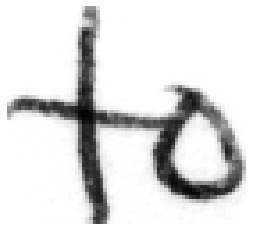

In [200]:
test_img = cv2.imread('/content/words/n06/n06-092/n06-092-00-12.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(test_img, cmap='gray')
plt.axis('off')
test_img = preprocess('/content/words/n06/n06-092/n06-092-00-12.png', 256, 64)
test_img = np.array(test_img).reshape(1, 256, 64, 1)
pred = model_predict.predict(test_img)
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
print('Prediction:{}'.format(num_to_label(decoded[0])))
print('==============')

# Conclusion

We have achieved 19.55% accuracy on Character level recognition and 22.57% on Word level recognition. The accuracy is low as we have used only a small portiong of the data (valid images of the first 10000 instances).

The model can be imporved by:
> - Using more training samples which will help the model to learn and generalise better
> - Using regenerated images
> - Cleaning the dataset eliminating the images which are not legible